## Download Data

In [ ]:
!pip install tensorflow==2.8.0

In [1]:
!pip install -U --no-cache-dir gdown --pre
# weather-dataset.zip
!gdown --id 1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F

In [ ]:
!unzip weather-dataset.zip

In [2]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Weather Recognition

In [4]:
# list đường dẫn các file ảnh
WEATHER_DATA_PATH = 'dataset'
path_imgs = list(glob.glob(WEATHER_DATA_PATH+'/**/*.jpg'))


In [5]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,sandstorm
1,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,lightning
2,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,fogsmog
3,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,hail
4,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,snow


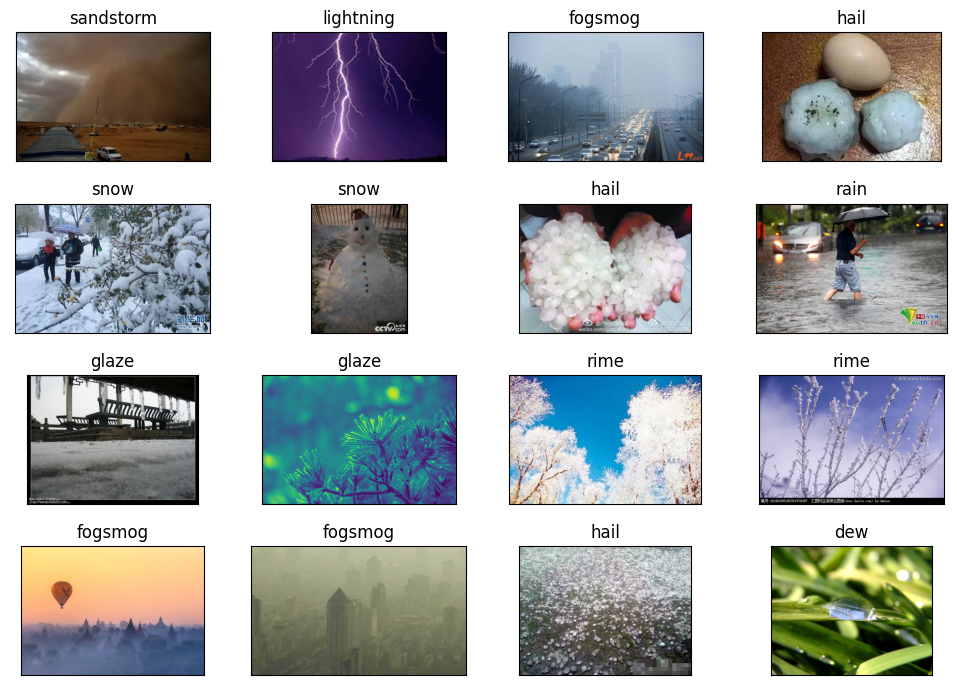

In [6]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

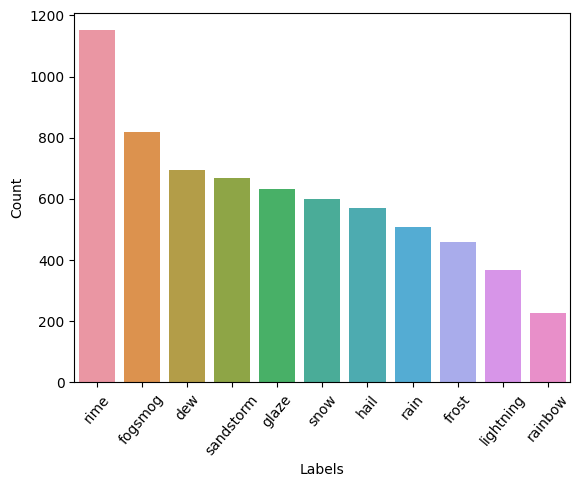

In [7]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [8]:
batch_size = 32
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


2022-12-28 13:41:46.024972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:41:46.053550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:41:46.053665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 13:41:46.054428: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


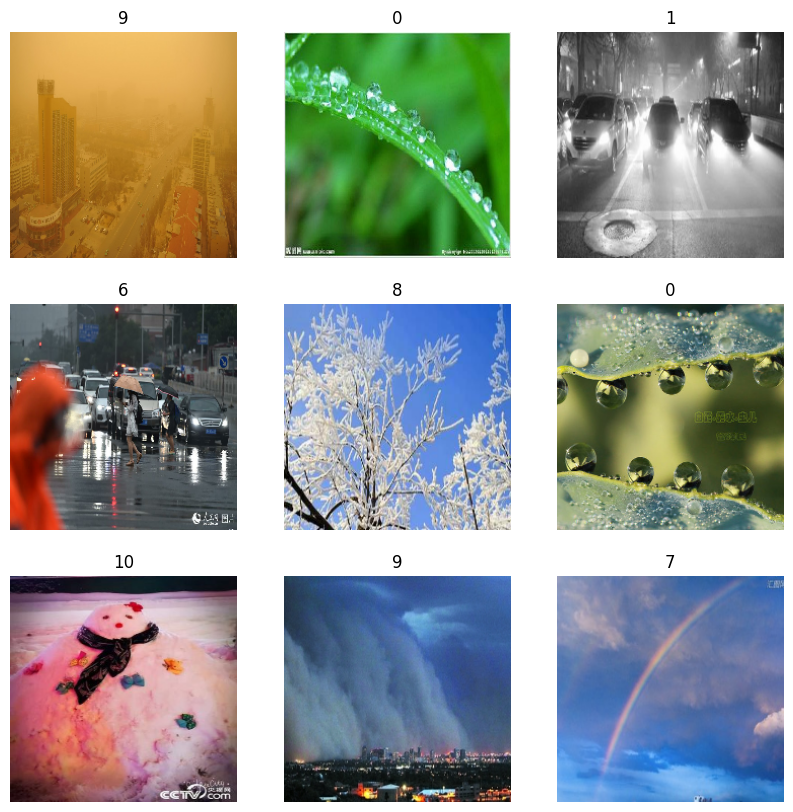

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

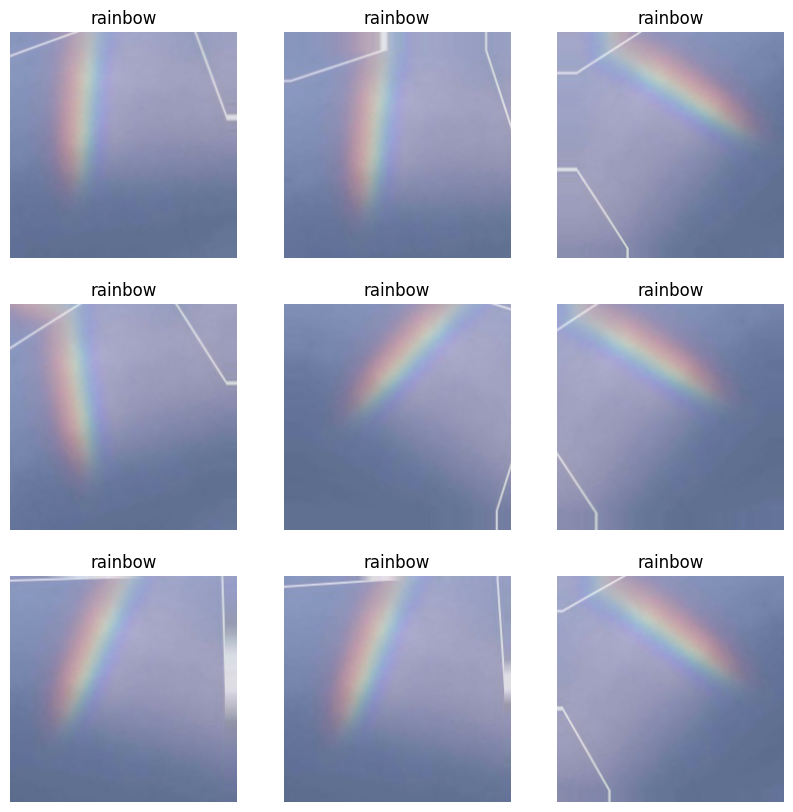

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

## DenseNet121 No Skip Connection

In [15]:
class BuildDensenet121_NoSkip():
    def __init__(self):
        pass
    
    
    def conv_block(self, inputs, k=32, is_skip_connection=True):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=4*k, kernel_size=(1,1), use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=k, kernel_size=(3,3), padding='same', use_bias=False)(x)
                
        return x
    
    
    def dense_block(self, x, nums_block, k=32):
        for i in range(nums_block):
            x = self.conv_block(x, 32)
        return x
        
    
    
    def trasition_layer(self, inputs, fraction=0.5):
        channels = inputs.shape[-1]
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=fraction*channels, kernel_size=(1,1), use_bias=False)(x)
        x = layers.AveragePooling2D(2, strides=2)(x)
        
        return x
    
    def build_model(self, classes, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        
        x = layers.ZeroPadding2D(padding=((3, 3)))(inputs)
        x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1)))(x)
        x = layers.MaxPooling2D(3, strides=2)(x)
        
        # 1-6
        x = self.dense_block(x, nums_block=6)
        x = self.trasition_layer(x)
        
        # 2-12
        x = self.dense_block(x, nums_block=12)
        x = self.trasition_layer(x)
        
        # 3-24
        x = self.dense_block(x, nums_block=24)
        x = self.trasition_layer(x)
        
        #4-16
        x = self.dense_block(x, nums_block=16)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=x)
        
        return model

In [16]:
build_densenet121 = BuildDensenet121_NoSkip()
densenet121_model_noskip = build_densenet121.build_model(classes=11)

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = densenet121_model_noskip(x)
weather_densenet121_model_noskip = Model(inputs=image_input, outputs=x)

weather_densenet121_model_noskip.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 11)                2422763   
                                                                 
Total params: 2,422,763
Trainable params: 2,403,851
Non-trainable params: 18,912
_________________________________________________________________


In [17]:
num_epochs = 50

weather_densenet121_model_noskip.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


history = weather_densenet121_model_noskip.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds)

Epoch 1/50


2022-12-28 13:41:52.613745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-12-28 13:41:53.485535: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


172/172 [==============================] - 17s 70ms/step - loss: 2.4158 - accuracy: 0.1370 - val_loss: 2.4143 - val_accuracy: 0.1115
Epoch 2/50
172/172 [==============================] - 11s 65ms/step - loss: 2.3909 - accuracy: 0.1486 - val_loss: 2.4082 - val_accuracy: 0.1115
Epoch 3/50
172/172 [==============================] - 11s 64ms/step - loss: 2.3792 - accuracy: 0.1526 - val_loss: 2.3934 - val_accuracy: 0.1166
Epoch 4/50
172/172 [==============================] - 11s 65ms/step - loss: 2.3570 - accuracy: 0.1548 - val_loss: 2.3918 - val_accuracy: 0.1356
Epoch 5/50
172/172 [==============================] - 11s 64ms/step - loss: 2.3548 - accuracy: 0.1552 - val_loss: 2.7727 - val_accuracy: 0.1443
Epoch 6/50
172/172 [==============================] - 11s 65ms/step - loss: 2.3446 - accuracy: 0.1557 - val_loss: 3.0308 - val_accuracy: 0.1363
Epoch 7/50
172/172 [==============================] - 11s 64ms/step - loss: 2.3448 - accuracy: 0.1592 - val_loss: 3.0225 - val_accuracy: 0.1414
Epo

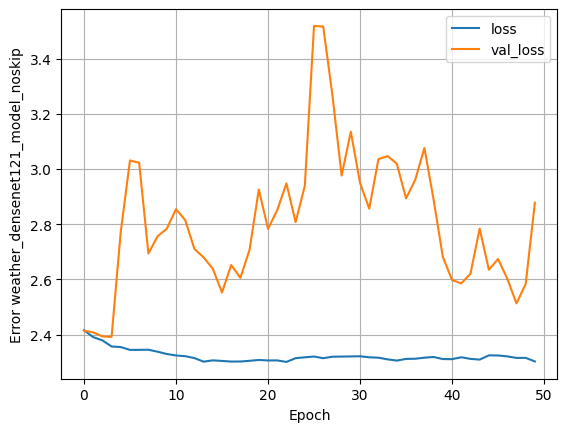

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error weather_densenet121_model_noskip')
plt.legend()
plt.grid(True)

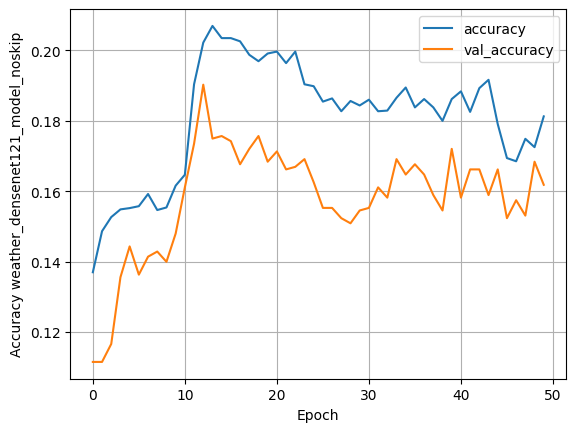

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy weather_densenet121_model_noskip')
plt.legend()
plt.grid(True)

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,2.324425,0.169399,2.673785,0.152332,45
46,2.321100,0.168488,2.602761,0.157434,46
47,2.315529,0.174863,2.513047,0.153061,47
48,2.315689,0.172495,2.583389,0.168367,48
49,2.302846,0.181239,2.877554,0.161808,49
